In [1]:
# List of imports.
import os
import os.path
import glob
from PIL import Image

import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [2]:
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, objective_error=None,
                      n_iter_check=1, n_iter_without_progress=50,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=None, kwargs=None):
    """Batch gradient descent with momentum and individual gains."""
    if args is None:
        args = []
    if kwargs is None:
        kwargs = {}

    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())
        
        new_error, grad = objective(p, *args, **kwargs)
        grad_norm = linalg.norm(grad)

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

        if (i + 1) % n_iter_check == 0:
            if new_error is None:
                new_error = objective_error(p, *args)
            error_diff = np.abs(new_error - error)
            error = new_error

            if verbose >= 2:
                m = "[t-SNE] Iteration %d: error = %.7f, gradient norm = %.7f"
                print(m % (i + 1, error, grad_norm))

            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: did not make any progress "
                          "during the last %d episodes. Finished."
                          % (i + 1, n_iter_without_progress))
                break
            if grad_norm <= min_grad_norm:
                if verbose >= 2:
                    print("[t-SNE] Iteration %d: gradient norm %f. Finished."
                          % (i + 1, grad_norm))
                break
            if error_diff <= min_error_diff:
                if verbose >= 2:
                    m = "[t-SNE] Iteration %d: error difference %f. Finished."
                    print(m % (i + 1, error_diff))
                break

        if new_error is not None:
            error = new_error
            
    return p, error, i

sklearn.manifold.t_sne._gradient_descent = _gradient_descent

In [3]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    counts = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", counts))

    # We create a scatter plot.
    f = plt.figure(figsize=(16, 16))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(counts):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(list_fams[i]), fontsize=8)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=2, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [4]:
imagedir = "malimg_dataset"

# Get number of samples per family
os.chdir(imagedir)  # the parent folder with sub-folders
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
total = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(total)
pos = 0
label = 0
for i in no_imgs:
    print("Label:%d\tFamily: %s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1

# Compute the features
width, height = (224,224)
X = np.zeros((sum(no_imgs), width*height))
cnt = 0
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    img_list = glob.glob('*.png')
    for j in range(len(img_list)):
        print("[%d] Processing image: %s" % (cnt, img_list[j]))
        im = Image.open(img_list[j])
        im1 = im.resize((width, height), Image.ANTIALIAS)
        des = np.array(im1.getdata(),np.uint8).reshape(width*height)
        X[cnt] = des[:]
        cnt += 1
    os.chdir('..')
os.chdir('..')

Label:0	Family: Adialer.C	Number of images: 122
Label:1	Family: Agent.FYI	Number of images: 116
Label:2	Family: Allaple.A	Number of images: 2949
Label:3	Family: Allaple.L	Number of images: 1591
Label:4	Family: Alueron.gen!J	Number of images: 198
Label:5	Family: Autorun.K	Number of images: 106
Label:6	Family: C2LOP.gen!g	Number of images: 200
Label:7	Family: C2LOP.P	Number of images: 146
Label:8	Family: Dialplatform.B	Number of images: 177
Label:9	Family: Dontovo.A	Number of images: 162
Label:10	Family: Fakerean	Number of images: 381
Label:11	Family: Instantaccess	Number of images: 431
Label:12	Family: Lolyda.AA1	Number of images: 213
Label:13	Family: Lolyda.AA2	Number of images: 184
Label:14	Family: Lolyda.AA3	Number of images: 123
Label:15	Family: Lolyda.AT	Number of images: 159
Label:16	Family: Malex.gen!J	Number of images: 136
Label:17	Family: Obfuscator.AD	Number of images: 142
Label:18	Family: Rbot!gen	Number of images: 158
Label:19	Family: Skintrim.N	Number of images: 80
Label:20

In [5]:
X.shape

(9339, 50176)

In [6]:
y.shape

(9339,)

In [7]:
X_proj = TSNE(random_state=1, perplexity=50, verbose=1).fit_transform(X)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 9339
[t-SNE] Computed conditional probabilities for sample 2000 / 9339
[t-SNE] Computed conditional probabilities for sample 3000 / 9339
[t-SNE] Computed conditional probabilities for sample 4000 / 9339
[t-SNE] Computed conditional probabilities for sample 5000 / 9339
[t-SNE] Computed conditional probabilities for sample 6000 / 9339
[t-SNE] Computed conditional probabilities for sample 7000 / 9339
[t-SNE] Computed conditional probabilities for sample 8000 / 9339
[t-SNE] Computed conditional probabilities for sample 9000 / 9339
[t-SNE] Computed conditional probabilities for sample 9339 / 9339
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.770190
[t-SNE] Error after 450 iterations: 0.770190


In [8]:
X_iter = np.dstack(position.reshape(-1, 2) for position in positions)

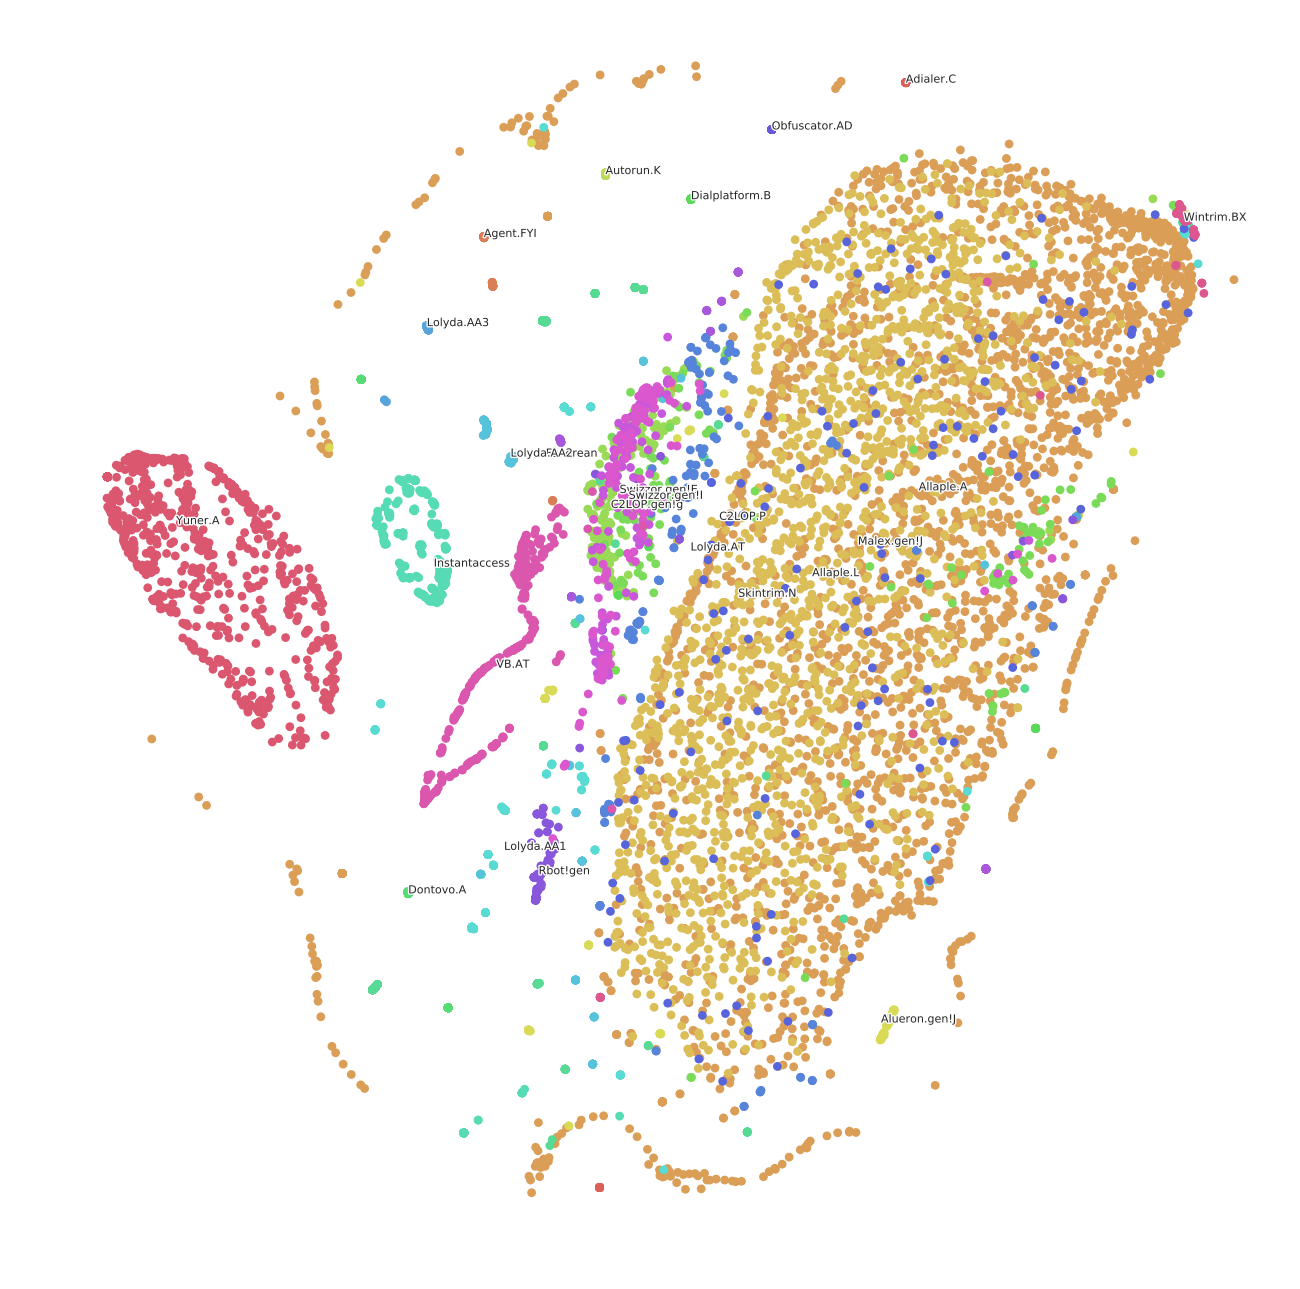

In [9]:
scatter(X_proj, y)
plt.savefig('images/malimg-tsne.png', dpi=120)

In [10]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

In [11]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

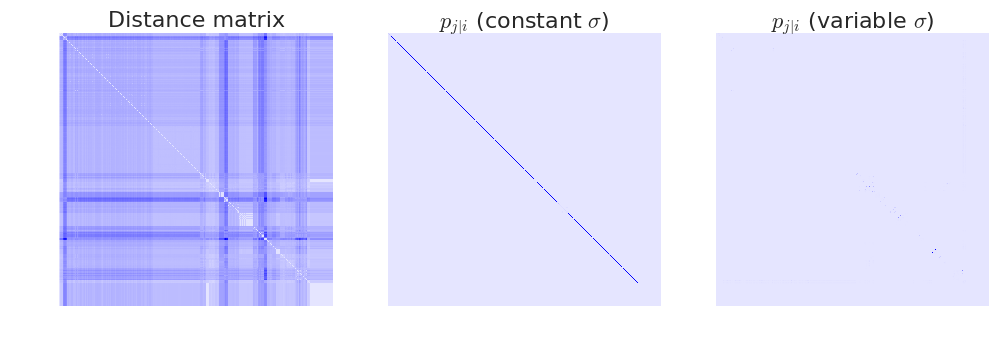

In [12]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

n_classes = len(np.unique(y))

plt.subplot(131)
plt.imshow(D[::n_classes, ::n_classes], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::n_classes, ::n_classes], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::n_classes, ::n_classes], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
plt.savefig('images/malimg-similarity.png', dpi=120)


[MoviePy] Building file images/malimg-tsne_animated.gif with imageio


100%|█████████▉| 225/226 [01:14<00:00,  2.93it/s]


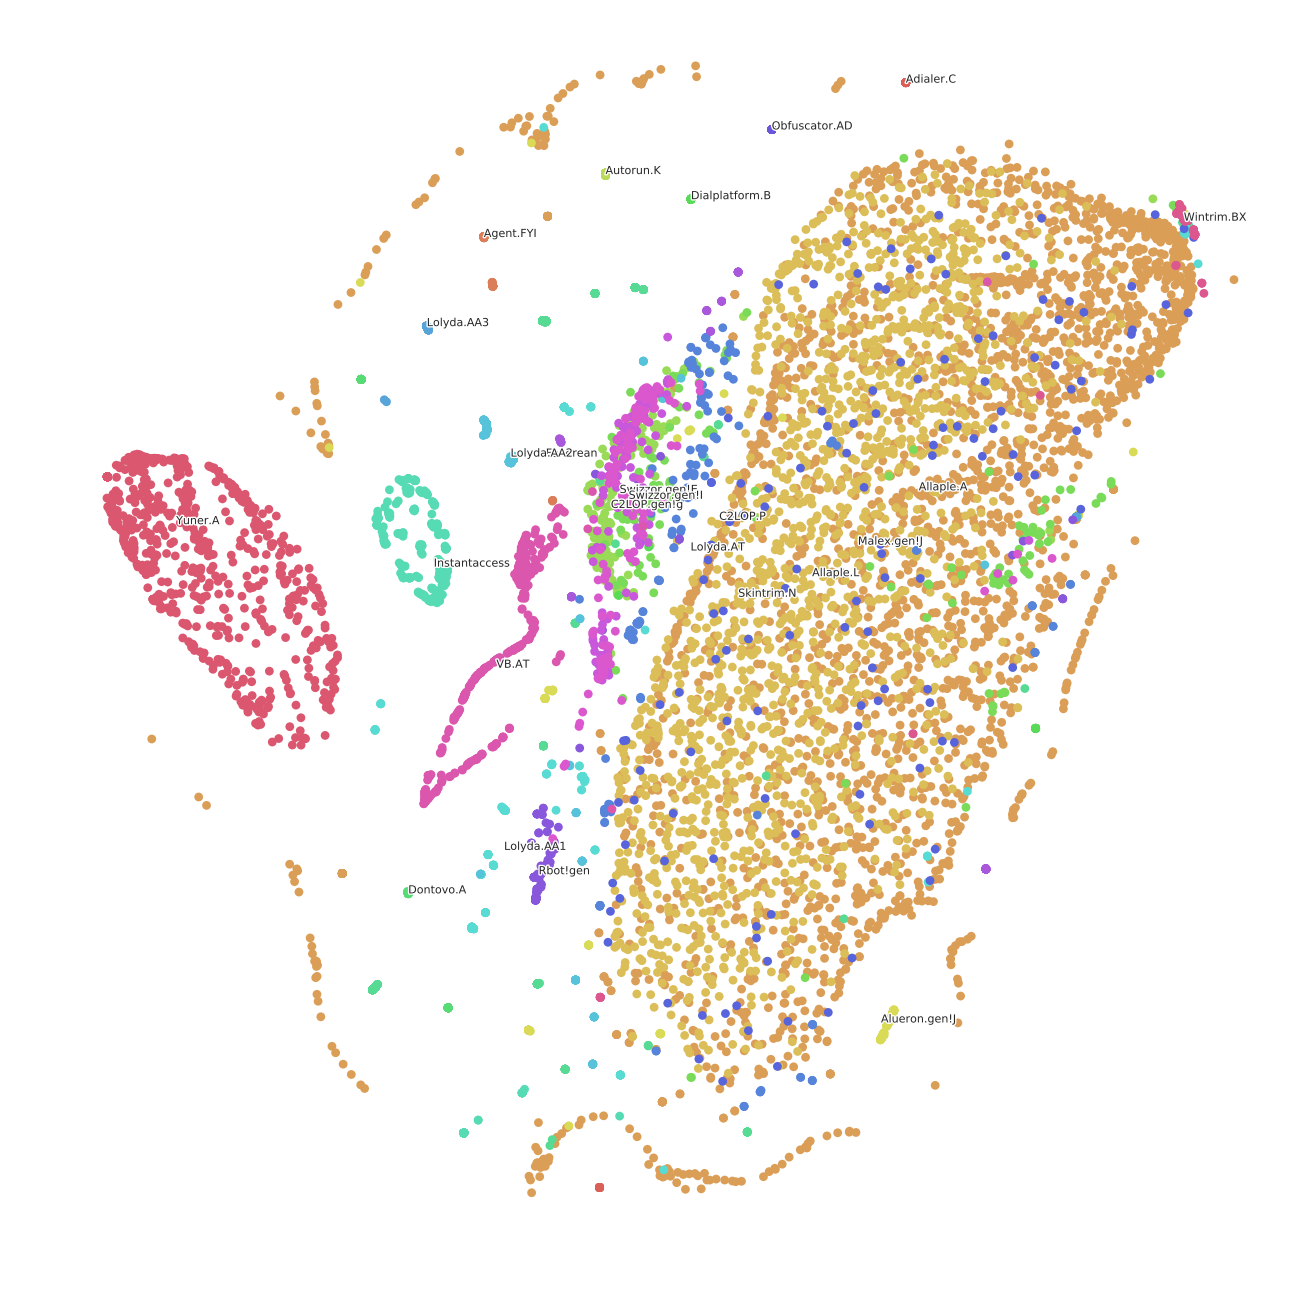

In [13]:
f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(n_classes), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("images/malimg-tsne_animated.gif", fps=20)


[MoviePy] Building file images/malimg-similarity_animated.gif with imageio


100%|█████████▉| 225/226 [1:02:40<00:16, 16.68s/it]


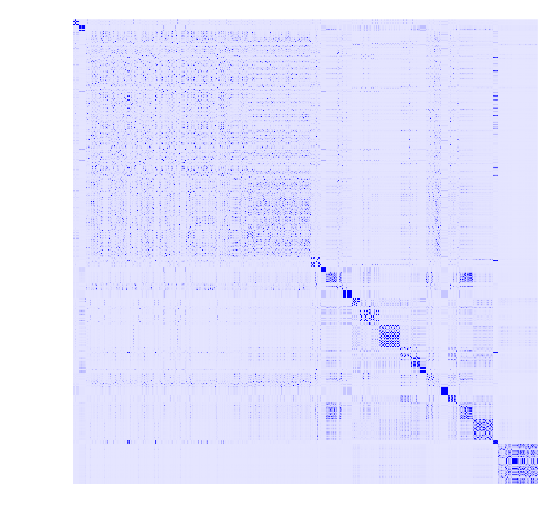

In [14]:
n = 1. / (pdist(X_iter[..., -1], "sqeuclidean") + 1)
Q = n / (2.0 * np.sum(n))
Q = squareform(Q)

f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
im = ax.imshow(Q, interpolation='none', cmap=pal)
plt.axis('tight')
plt.axis('off')

def make_frame_mpl(t):
    i = int(t*40)
    n = 1. / (pdist(X_iter[..., i], "sqeuclidean") + 1)
    Q = n / (2.0 * np.sum(n))
    Q = squareform(Q)
    im.set_data(Q)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("images/malimg-similarity_animated.gif", fps=20)